### 0. Import libraries

In [182]:
# Torch and Torchlightning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Import Pytorch modules
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

# pytorch model summary 
from pytorch_model_summary import summary

# Sklearn for onehote encoding
from sklearn.preprocessing import LabelEncoder

# pandas
import pandas as pd

#Plotting tools 
import matplotlib.pyplot as plt

# some other utility modules
import random
import ast
import os

# Imports for SandiaPV
from pvlib import irradiance, temperature, pvsystem
from sandiapv_energy_prediction import *

## 1. Define model

In [183]:
 
class EnergyPredictionModel(nn.Module):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size, dropout_rate=0.2):
        super(EnergyPredictionModel, self).__init__()
        self.dynamic_rnn1 = nn.LSTM(input_size=dynamic_feature_size, hidden_size=hidden_size, batch_first=True)
        self.dynamic_rnn2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        
        # Increased depth in fully connected layers
        self.fc1 = nn.Linear(hidden_size + static_feature_size, 2*hidden_size)  
        self.fc2 = nn.Linear(2*hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 3)
        
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid() 

        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)
            
    def forward(self, dynamic_features, static_features):
        # Two LSTM layers
        output, _ = self.dynamic_rnn1(dynamic_features)
        output, (h_n, _) = self.dynamic_rnn2(output)
        h_n = h_n.squeeze(0)
        
        concatenated_features = torch.cat((h_n, static_features), dim=1)
        
        x = self.fc1(concatenated_features)
        x = self.gelu(x)
        #x = self.dropout(x)
        x = self.fc2(x)
        x = self.gelu(x)
        #x = self.dropout(x)
        x = self.fc3(x)

        output = self.sigmoid(x)
        
        return output

## 2. Define training class


In [184]:
# class TrainEnergyPrediction(pl.LightningModule):
#     def __init__(self, dynamic_feature_size, static_feature_size, hidden_size, learning_rate):
#         super().__init__()
#         self.save_hyperparameters()
#         self.model = EnergyPredictionModel(dynamic_feature_size, static_feature_size, hidden_size)
#         self.loss_fn = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
#         self.train_losses = []
#         self.validation_losses = []
#         self.test_losses = []
#         self.learning_rate = learning_rate
#     def forward(self, x_dynamic, x_static):
#         return self.model(x_dynamic, x_static)
    
#     def training_step(self, batch, batch_idx):
#         x_dynamic, x_static, y_true = batch
#         y_pred = self(x_dynamic, x_static)

#         loss = self.loss_fn(y_pred.float(), y_true.float())  
#         self.log('train_loss', loss)
#         self.train_losses.append(loss.item())
#         return loss
#     """"
#     def validation_step(self, batch, batch_idx):
#         x_dynamic, x_static, y_true = batch
#         y_pred = self(x_dynamic, x_static)
#         y_pred_log = nn.functional.log_softmax(y_pred, dim=-1)
#         val_loss = self.loss_fn(y_pred_log, y_true)
#         self.log('val_loss', val_loss)
#         self.validation_losses.append(val_loss.item())
#         return val_loss
#     """.float
#     def test_step(self, batch, batch_idx):
#         x_dynamic, x_static, y_true = batch
#         y_pred = self(x_dynamic, x_static)
#         y_pred_log = nn.functional.log_softmax(y_pred, dim=-1)
#         test_loss = self.loss_fn(y_pred_log, y_true)
#         self.log('test_loss', test_loss)
#         self.test_losses.append(test_loss.item())
#         return test_loss
#     """
#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
#         return optimizer

In [185]:
def calculate_gaussian_auc(amplitude, mean, std_dev):
    # Define a range of x values to compute the Gaussian function
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 1000)
    gaussian_curve = amplitude * np.exp(-((x - mean) ** 2) / (2 * std_dev ** 2))
    auc = np.trapz(gaussian_curve, x)
    return auc

class TrainEnergyPrediction(pl.LightningModule):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size, learning_rate, loss_type='mse', lambda_auc=3.0):
        super().__init__()
        self.save_hyperparameters()
        self.model = EnergyPredictionModel(dynamic_feature_size, static_feature_size, hidden_size)
        
        if loss_type == 'mse':
            self.loss_fn = nn.MSELoss(reduction='sum')
        elif loss_type == 'l1':
            self.loss_fn = nn.L1Loss(reduction='sum')
        elif loss_type == 'nll':
            self.loss_fn = nn.NLLLoss(reduction='sum')
        else:
            raise ValueError("Unsupported loss type. Choose from 'mse', 'l1', 'nll'.")
        
        self.train_losses = []
        self.validation_losses = []
        self.avg_train_losses = []
        self.avg_validation_losses = []
        self.test_losses = []
        self.delta_auc_errors = []
        self.learning_rate = learning_rate
        self.lambda_auc = lambda_auc

    def forward(self, x_dynamic, x_static):
        return self.model(x_dynamic, x_static)
    
    def calculate_delta_auc(self, y_pred, y_true):
        y_pred = y_pred.detach().cpu().numpy()
        y_true = y_true.detach().cpu().numpy()
        delta_aucs = []
        
        for i in range(len(y_true)):
            pred_auc = calculate_gaussian_auc(*y_pred[i])
            true_auc = calculate_gaussian_auc(*y_true[i])
            delta_aucs.append((pred_auc, true_auc))
        
        return delta_aucs

    def combined_loss(self, y_pred, y_true, pred_aucs, true_aucs):
        # MSE Loss for the parameters
        param_loss = self.loss_fn(y_pred, y_true)
        
        # Delta AUC Loss
        auc_loss = self.loss_fn(pred_aucs, true_aucs)
        #print(auc_loss,param_loss)
        # Combined Loss
        total_loss = param_loss + self.lambda_auc * auc_loss
        return total_loss

    def training_step(self, batch, batch_idx):
        x_dynamic, x_static, y_true = batch
        y_pred = self(x_dynamic, x_static)

        # Calculate AUCs
        aucs = self.calculate_delta_auc(y_pred.float(), y_true.float())
        
        # Calculate loss between predicted and true AUCs
        pred_aucs, true_aucs = zip(*aucs)
        pred_aucs = torch.tensor(pred_aucs, dtype=torch.float32, requires_grad=True)
        true_aucs = torch.tensor(true_aucs, dtype=torch.float32)

        # Combined loss
        loss = self.combined_loss(y_pred.float(), y_true.float(), pred_aucs, true_aucs)
        
        self.log('train_loss', loss)
        self.train_losses.append(loss.item())
        print(loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x_dynamic, x_static, y_true = batch
        y_pred = self(x_dynamic, x_static)
        
        # Calculate AUCs
        aucs = self.calculate_delta_auc(y_pred.float(), y_true.float())
        
        # Calculate loss between predicted and true AUCs
        pred_aucs, true_aucs = zip(*aucs)
        pred_aucs = torch.tensor(pred_aucs, dtype=torch.float32)
        true_aucs = torch.tensor(true_aucs, dtype=torch.float32)

        # Combined loss
        test_loss = self.combined_loss(y_pred.float(), y_true.float(), pred_aucs, true_aucs)
        
        self.log('test_loss', test_loss)
        self.test_losses.append(test_loss.item())
        
        return {'test_loss': test_loss}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer



<style>
div.cell, div.input_area, div.output_area {
    background-color: #f0f0f0; /* Light grey color */
}
</style>

## 3. Load dataset

In [186]:
class SolarPanelDataset(Dataset):
    def __init__(self, csv_file):
        self.data_frame = pd.read_csv(csv_file, converters={
            'temperature_sequence': ast.literal_eval, 
            'wind_speed_sequence': ast.literal_eval, 
            'dni_sequence': ast.literal_eval, 
            'dhi_sequence': ast.literal_eval, 
            'global_irradiance_sequence': ast.literal_eval, 
            'gaussian_params': lambda x: [float(i) for i in x.strip('[]').split()]
        })
        
        # Label encoding for categorical variables
        self.encoder_panel = LabelEncoder()
        self.encoder_module = LabelEncoder()
        #self.data_frame['panel_type'] = self.encoder_panel.fit_transform(self.data_frame['panel_type'])
        self.data_frame['module_type'] = self.encoder_module.fit_transform(self.data_frame['module_type'])

        # Normalize static and dynamic features
        self.normalize_features()

        # Normalize outputs and store normalization parameters
        self.output_means = []
        self.output_stds = []
        self.normalize_outputs()

    def normalize_features(self):
        # Normalize static numeric features
        for feature in ['tilt', 'azimuth']:
            mean = self.data_frame[feature].mean()
            std = self.data_frame[feature].std()
            if std > 0:
                self.data_frame[feature] = (self.data_frame[feature] - mean) / std
            else:
                self.data_frame[feature] = 0  

        # Normalizing dynamic features
        dynamic_cols = ['temperature_sequence', 'wind_speed_sequence', 'dni_sequence', 'dhi_sequence', 'global_irradiance_sequence']
        for col in dynamic_cols:
            col_data = np.concatenate(self.data_frame[col].values)
            mean = col_data.mean()
            std = col_data.std()
            if std > 0:
                self.data_frame[col] = self.data_frame[col].apply(lambda x: (np.array(x) - mean) / std)
            else:
                self.data_frame[col] = self.data_frame[col].apply(lambda x: np.zeros_like(x))  

    def normalize_outputs(self):
        # Normalize Gaussian output parameters using min-max scaling
        gaussian_array = np.array(self.data_frame['gaussian_params'].tolist())
        self.output_mins = gaussian_array.min(axis=0)
        self.output_maxs = gaussian_array.max(axis=0)

        # Avoid division by zero in case max == min
        range = self.output_maxs - self.output_mins
        range[range == 0] = 1  # prevent division by zero

        normalized_gaussian = (gaussian_array - self.output_mins) / range
        self.data_frame['gaussian_params'] = list(normalized_gaussian)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Static features
        static_features = self.data_frame.iloc[idx][[ 'tilt', 'azimuth', 'module_type']].astype(np.float32).to_numpy()
        static_features = torch.tensor(static_features)
        
        # Dynamic features 
        dynamic_features = np.column_stack([
            self.data_frame.iloc[idx]['temperature_sequence'],
            self.data_frame.iloc[idx]['wind_speed_sequence'],
            self.data_frame.iloc[idx]['dni_sequence'],
            self.data_frame.iloc[idx]['dhi_sequence'],
            self.data_frame.iloc[idx]['global_irradiance_sequence']
        ]).astype(np.float32)
        dynamic_features = torch.tensor(dynamic_features)

        # Gaussian parameters as output, normalized
        outputs = torch.tensor(self.data_frame.iloc[idx]['gaussian_params'])

        return dynamic_features, static_features, outputs

    def denormalize_output(self, normalized_output):
        # Convert normalized output back to original scale
        denormalized_output = normalized_output.numpy() * (self.output_maxs - self.output_mins) + self.output_mins
        return denormalized_output

# Example usage
#dataset = SolarPanelDataset('energy_data/model_input.csv')
dataset = SolarPanelDataset('energy_data/dataset_to_train_model.csv')
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)

for i, data in enumerate(data_loader):
    if i > 16:
        break
    dynamic_inputs, static_inputs, outputs = data
    print("Static Inputs:", static_inputs) # Panel type, tilt, azimuth, module type
    print("Dynamic Inputs Shape:", dynamic_inputs.shape) # Temperature, Wind, dni, dhi, global irradiance
    print("Outputs:", outputs) # Gaussian: Amplitude, Mean, standard deviation (normalized)

    # Example to denormalize the output for the first batch
    #if i == 0:
    #    denormalized_outputs = [dataset.denormalize_output(output) for output in outputs]
    #     print("Denormalized Outputs:", denormalized_outputs)


Static Inputs: tensor([[-0.6211, -0.8498,  0.0000],
        [ 1.5336,  0.4714,  0.0000],
        [-1.5481, -0.5012,  0.0000],
        [ 0.0706, -0.4271,  1.0000],
        [-0.4618, -0.8642,  0.0000],
        [ 0.1256, -0.8868,  1.0000],
        [ 1.6934, -1.5468,  0.0000],
        [ 0.0805,  1.5615,  0.0000],
        [-0.2140, -1.2793,  1.0000],
        [-0.8148,  1.4431,  0.0000],
        [ 0.3428,  1.8228,  0.0000],
        [-1.1258,  1.7498,  0.0000],
        [ 0.6244,  1.4336,  0.0000],
        [-0.7346,  1.7874,  0.0000],
        [-1.2275, -0.6255,  0.0000],
        [-2.2489,  1.7230,  0.0000],
        [ 0.9163, -1.2553,  0.0000],
        [-0.4501, -0.5500,  0.0000],
        [ 0.0416,  0.7921,  0.0000],
        [ 0.2631, -1.2621,  0.0000],
        [ 1.4016,  0.0025,  1.0000],
        [-0.7108,  0.0422,  1.0000],
        [ 1.0137, -1.2278,  1.0000],
        [ 0.0558,  0.9253,  0.0000],
        [ 0.9837,  0.9297,  1.0000],
        [-0.8911,  0.0385,  0.0000],
        [ 0.8781, -0.35

## 4. Train model

In [187]:
# Initialize the model
dynamic_feature_size = 5
static_feature_size = 3
hidden_size = 128
learning_rate = 1e-4

# Initialize the Lightning module
train_module = TrainEnergyPrediction(dynamic_feature_size,static_feature_size,hidden_size, learning_rate, loss_type='nll', lambda_auc=3.0)
model = train_module.model 
print(model)
#print(summary(model, [(dynamic_feature_size,), (static_feature_size,)]))

# Set up TensorBoard logger
log_dir = "tb_logs/my_model"
print("Log directory contents:", os.listdir(log_dir))
logger = TensorBoardLogger("tb_logs", name="my_model")

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=5, logger =logger)
    
# Fit the model to the training data
trainer.fit(train_module, train_dataloaders=data_loader)

EnergyPredictionModel(
  (dynamic_rnn1): LSTM(5, 128, batch_first=True)
  (dynamic_rnn2): LSTM(128, 128, batch_first=True)
  (fc1): Linear(in_features=131, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
)
Log directory contents: ['version_10', 'version_100', 'version_101', 'version_102', 'version_103', 'version_104', 'version_105', 'version_106', 'version_107', 'version_108', 'version_109', 'version_11', 'version_110', 'version_111', 'version_112', 'version_113', 'version_114', 'version_115', 'version_116', 'version_117', 'version_118', 'version_119', 'version_12', 'version_120', 'version_121', 'version_122', 'version_123', 'version_124', 'version_125', 'version_126', 'version_127', 'version_128', 'version_129', 'version_13', 'version_130', 'version_131', 'version_132', 'version_133',

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 268 K 
1 | loss_fn | NLLLoss               | 0     
--------------------------------------------------
268 K     Trainable params
0         Non-trainable params
268 K     Total params
1.073     Total estimated model params size (MB)
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

## 5. Inspect performance

[114.72174835205078, 112.57276153564453, 112.02969360351562, 110.13777160644531, 125.72592163085938, 120.18375396728516, 114.61351776123047, 119.30577087402344, 114.10638427734375, 121.29850769042969, 113.38116455078125, 117.31396484375, 116.65419006347656, 120.66973114013672, 114.43948364257812, 116.87617492675781, 111.42861938476562, 113.15750122070312, 112.6085205078125, 101.43157958984375, 112.89071655273438, 107.89622497558594, 117.5482177734375, 116.03677368164062, 108.42327880859375, 108.13214111328125, 109.0289306640625, 117.45619201660156, 113.97714233398438, 117.46986389160156, 113.30921936035156, 108.97917938232422, 111.38095092773438, 115.97970581054688, 108.27313232421875, 105.1649398803711, 114.53912353515625, 122.46914672851562, 110.89015197753906, 112.47528839111328, 115.35658264160156, 110.74790954589844, 113.93135070800781, 122.40000915527344, 117.94178009033203, 104.1765365600586, 113.2572250366211, 111.12249755859375, 126.3448257446289, 118.56536865234375, 114.37409

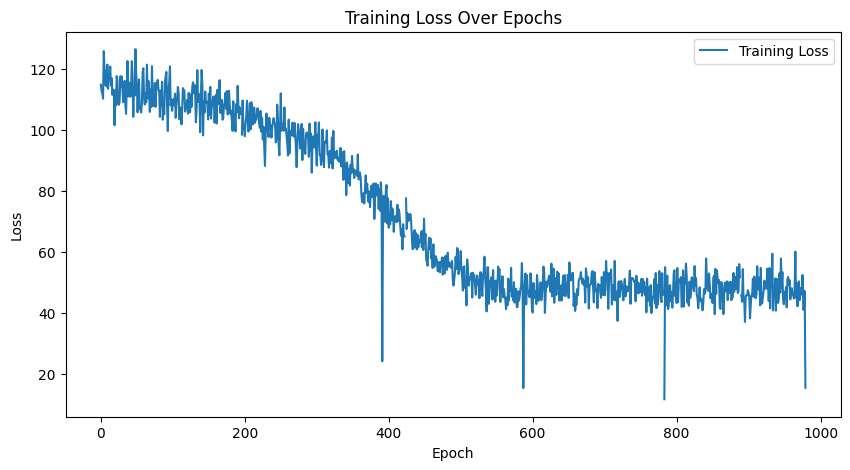

114.72174835205078
112.57276153564453
112.02969360351562
110.13777160644531
125.72592163085938
120.18375396728516
114.61351776123047
119.30577087402344
114.10638427734375
121.29850769042969
113.38116455078125
117.31396484375
116.65419006347656
120.66973114013672
114.43948364257812
116.87617492675781
111.42861938476562
113.15750122070312
112.6085205078125
101.43157958984375
112.89071655273438
107.89622497558594
117.5482177734375
116.03677368164062
108.42327880859375
108.13214111328125
109.0289306640625
117.45619201660156
113.97714233398438
117.46986389160156
113.30921936035156
108.97917938232422
111.38095092773438
115.97970581054688
108.27313232421875
105.1649398803711
114.53912353515625
122.46914672851562
110.89015197753906
112.47528839111328
115.35658264160156
110.74790954589844
113.93135070800781
122.40000915527344
117.94178009033203
104.1765365600586
113.2572250366211
111.12249755859375
126.3448257446289
118.56536865234375
114.37409973144531
105.6724624633789
112.00782775878906
116.

In [ ]:
print(train_module.train_losses)
# After training
plt.figure(figsize=(10, 5))
plt.plot(train_module.train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

for i in  train_module.train_losses:
    print(i)


#### Launch tensorboard for advanced training insights

In [ ]:
#Launch tensorboard for advanced training insights.
os.system(f"taskkill /pid 19988 /F")

# Reload the TensorBoard extension to avoid errors about it being already loaded
%reload_ext tensorboard

# Start TensorBoard
%tensorboard --logdir tb_logs/my_model

Reusing TensorBoard on port 6006 (pid 9616), started 1 day, 21:37:59 ago. (Use '!kill 9616' to kill it.)

### Use model

tensor([[0.2186, 0.4088, 0.5286]]) torch.Size([1, 3])
[[0.21859473 0.40877813 0.52864456]] (1, 3)


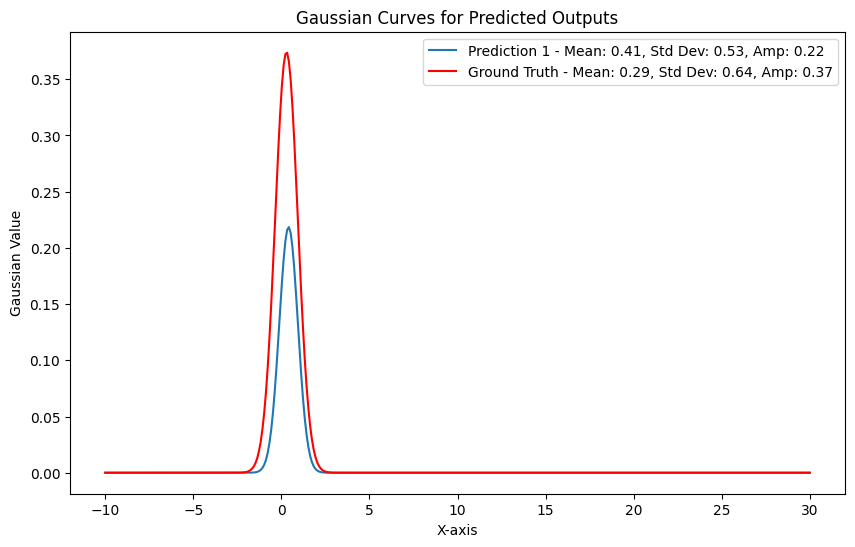

In [ ]:
# Load the trained model
trained_model = train_module 
trained_model.eval() 

# Get a single sample from the data loader
sample_dynamic, sample_static, ground_truth = next(iter(data_loader))
sample =5
# Predict using a single example
with torch.no_grad():
    predictions = trained_model(sample_dynamic[sample].unsqueeze(0), sample_static[sample].unsqueeze(0))
print(predictions,predictions.shape)

# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to plot Gaussian curves
def plot_gaussian(x, predictions,ground_truth, labels):
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, label in enumerate(labels):
        a, b, c = predictions[i]
        y = gaussian(x, a, b, c)
        ax.plot(x, y, label=f'{label} - Mean: {b:.2f}, Std Dev: {c:.2f}, Amp: {a:.2f}')
    
     # Plot ground truth Gaussian curves
    gt_a, gt_b, gt_c = ground_truth[0]
    gt_y = gaussian(x, gt_a, gt_b, gt_c)
    ax.plot(x, gt_y, label=f'Ground Truth - Mean: {gt_b:.2f}, Std Dev: {gt_c:.2f}, Amp: {gt_a:.2f}', color='red')
    

    ax.set_title('Gaussian Curves for Predicted Outputs')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Gaussian Value')
    ax.legend()
    plt.show()

# Prepare x-axis for the plot
x_values = np.linspace(-10, 30, 400)

# Reshape predictions if necessary and convert to numpy if still in tensor form
predictions = predictions.squeeze().numpy().reshape(1, -1)
predictions = predictions
print(predictions, predictions.shape)
ground_truth = ground_truth[sample].squeeze().numpy().reshape(1, -1)
# Plot the Gaussian curve for the predicted values
plot_gaussian(x_values, predictions,ground_truth, labels=["Prediction 1"])

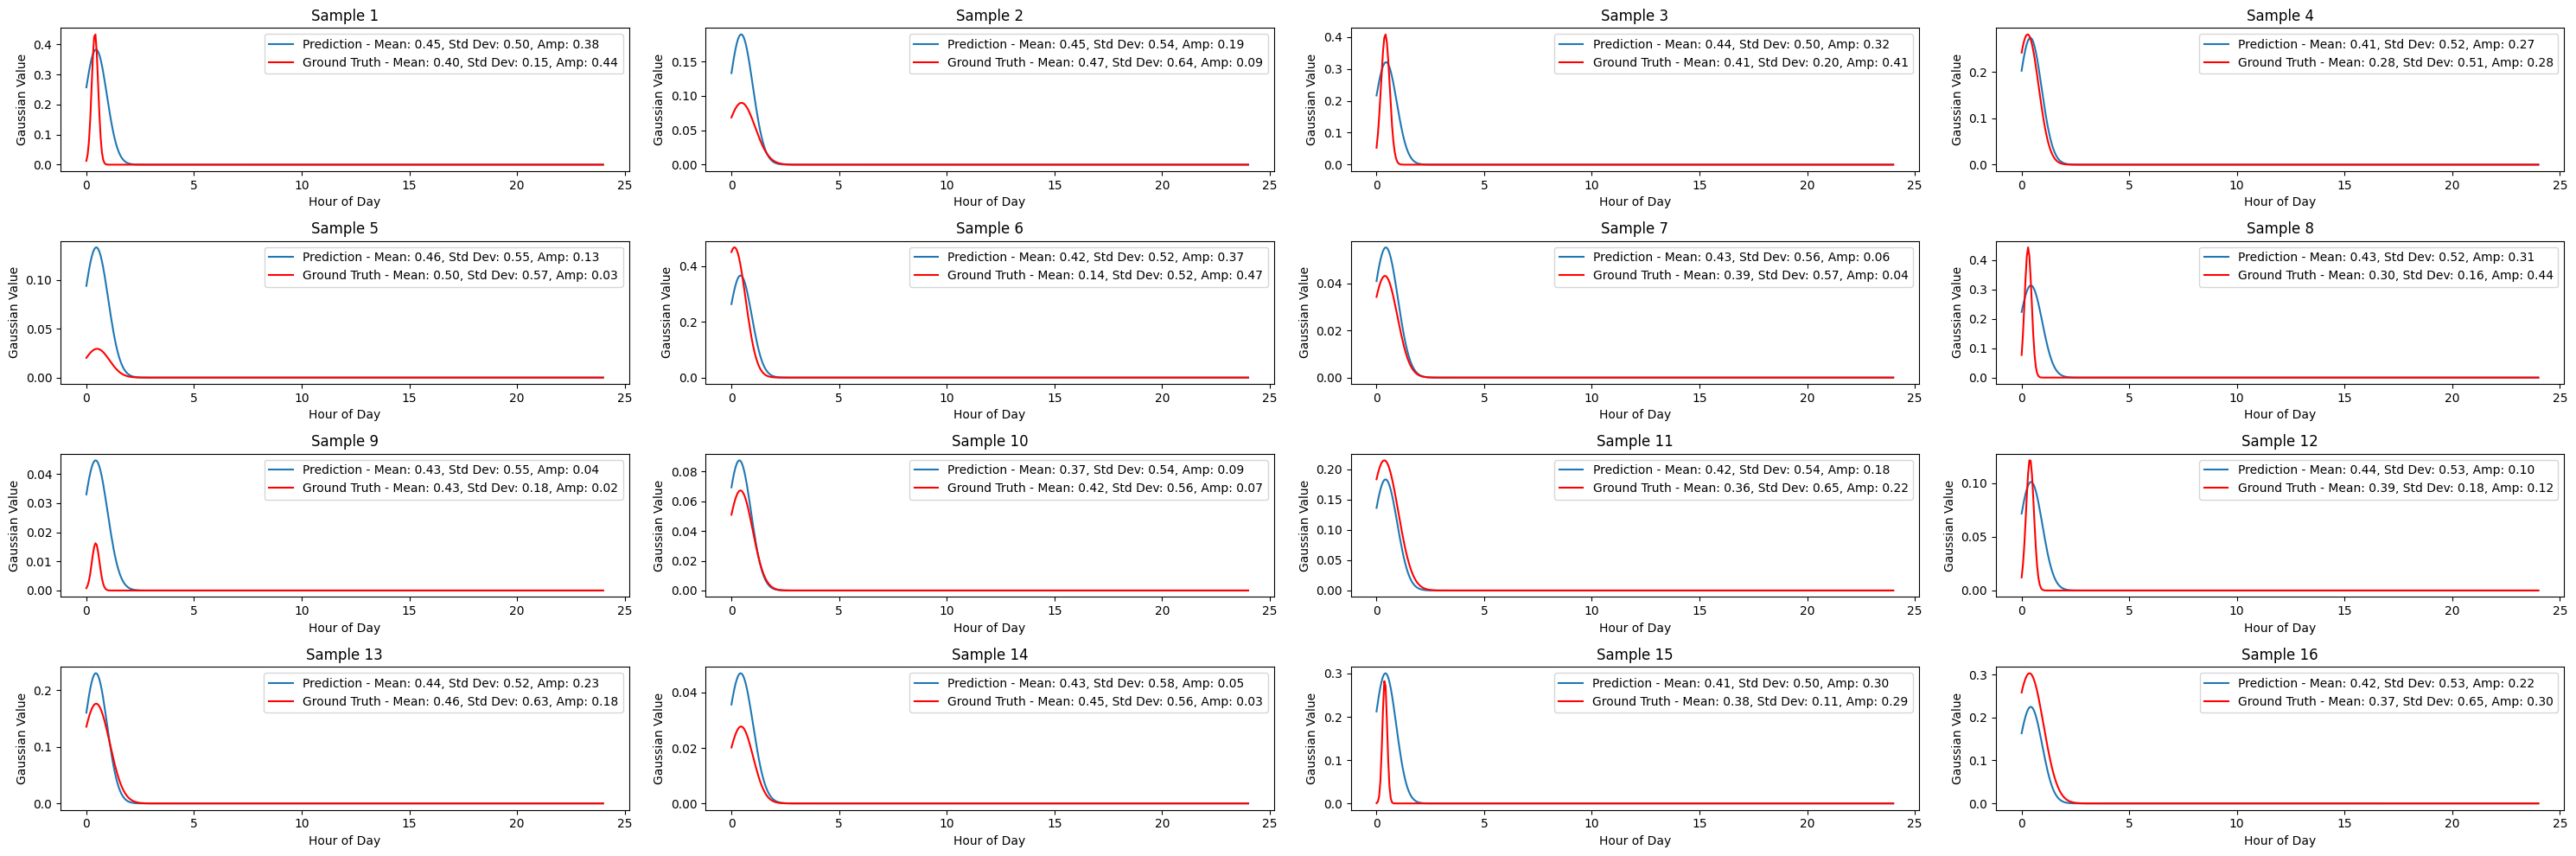

In [ ]:
# Load the trained model
trained_model = train_module
trained_model.eval()

# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to plot Gaussian curves for multiple samples
def plot_gaussian(samples, x, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(30, 10))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_a, pred_b, pred_c = predictions[i] # dataset.denormalize_output(predictions[i])
        gt_a, gt_b, gt_c = ground_truth[i] # dataset.denormalize_output(ground_truth[i])
        
        # Calculate Gaussian curves
        pred_y = gaussian(x, pred_a, pred_b, pred_c)
        gt_y = gaussian(x, gt_a, gt_b, gt_c)
        
        # Plot curves
        ax.plot(x, pred_y, label=f'Prediction - Mean: {pred_b:.2f}, Std Dev: {pred_c:.2f}, Amp: {pred_a:.2f}')
        ax.plot(x, gt_y, label=f'Ground Truth - Mean: {gt_b:.2f}, Std Dev: {gt_c:.2f}, Amp: {gt_a:.2f}', color='red')
        ax.set_title(f'Sample {i+1}')
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Gaussian Value')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Prepare x-axis for the plot (hours of the day)
x_values = np.linspace(0, 24, 400)

# Number of samples to plot and subplots configuration
num_samples = 16 
rows = 4
cols = 4  

# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(data_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = trained_model(samples_dynamic, samples_static)

# Reshape predictions and ground truth if necessary and convert to numpy if still in tensor form
predictions = predictions.numpy()
ground_truth = ground_truth.numpy()

# Plot the Gaussian curves for the predicted values and ground truth
plot_gaussian(num_samples, x_values, predictions, ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)


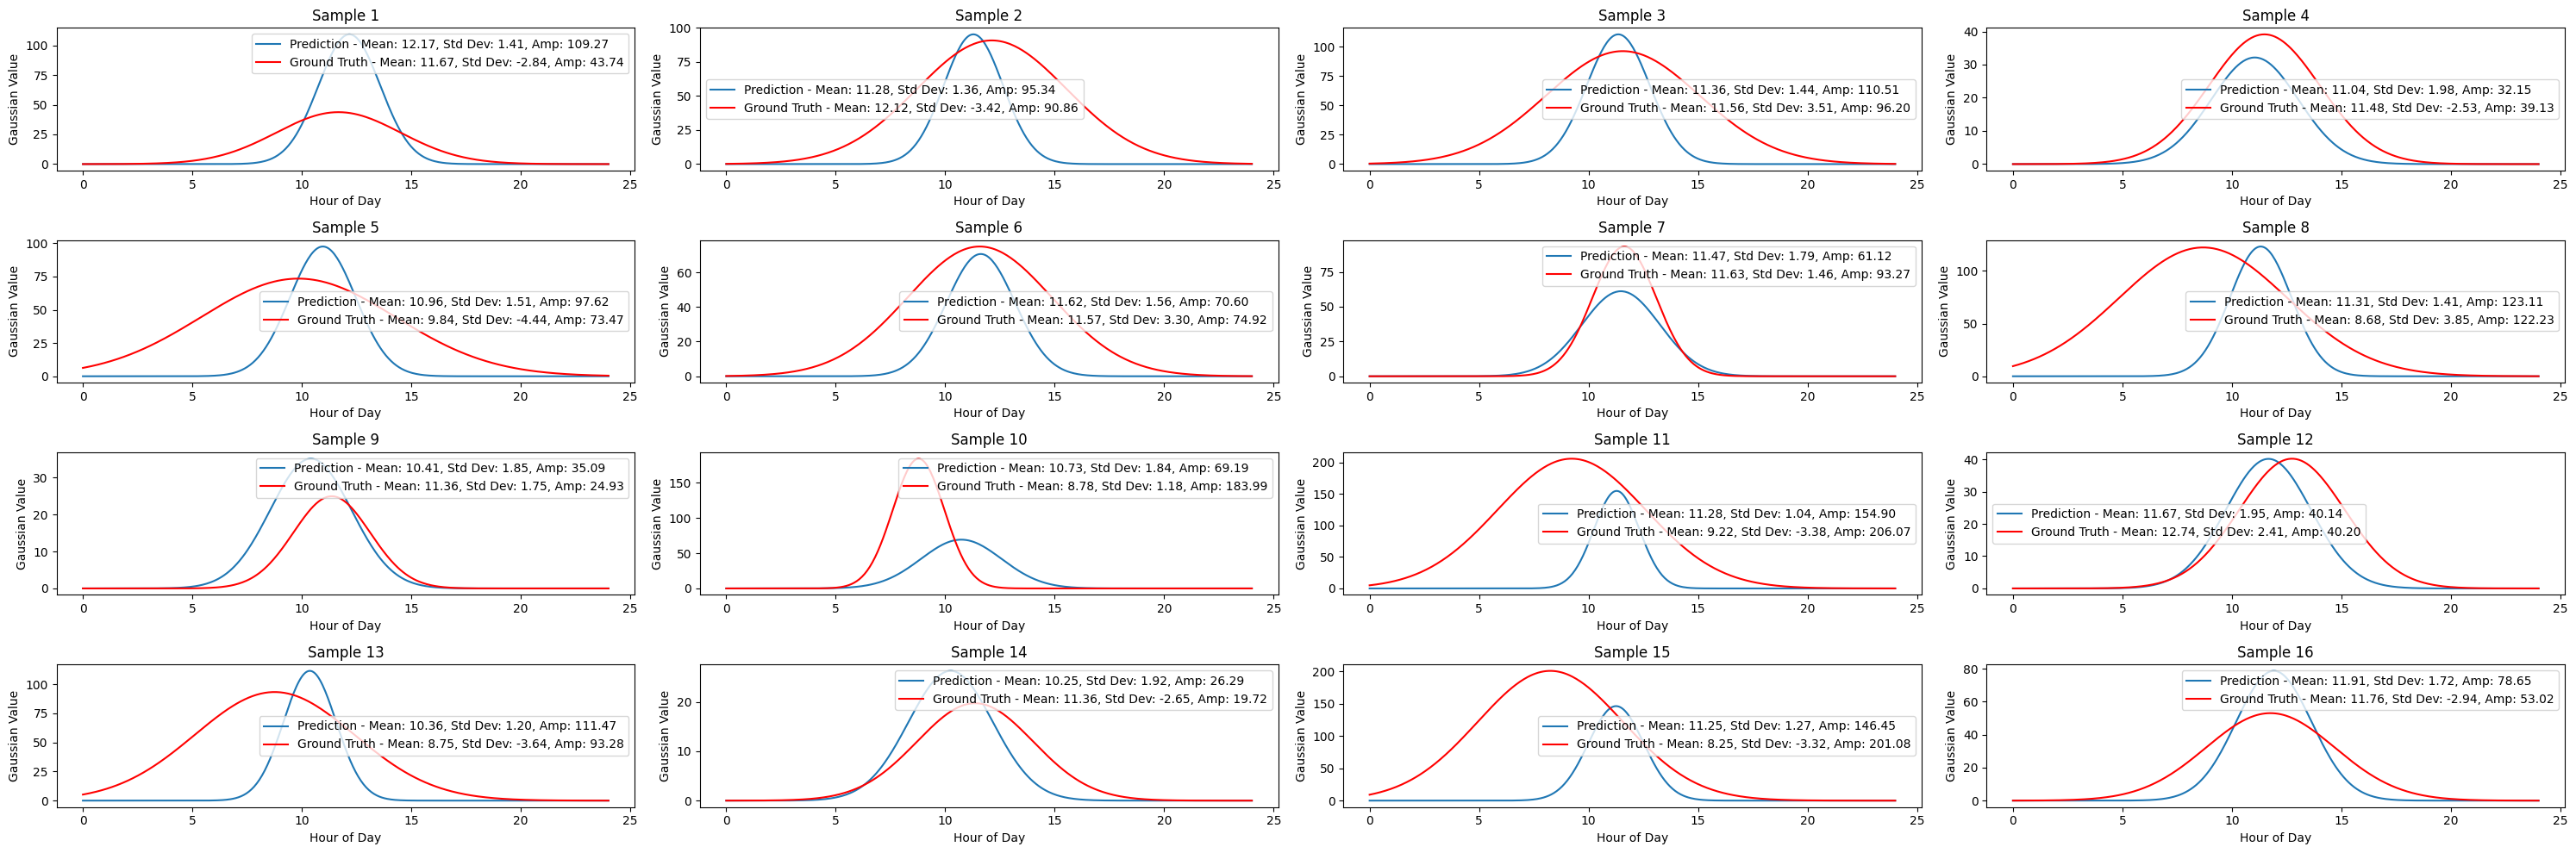

In [ ]:
# Load the trained model
trained_model = train_module
trained_model.eval()

# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to plot Gaussian curves for multiple samples
def plot_gaussian(samples, x, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(30, 10))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_a, pred_b, pred_c = dataset.denormalize_output(predictions[i])
        gt_a, gt_b, gt_c =  dataset.denormalize_output(ground_truth[i])
        
        # Calculate Gaussian curves
        pred_y = gaussian(x, pred_a, pred_b, pred_c)
        gt_y = gaussian(x, gt_a, gt_b, gt_c)
        
        # Plot curves
        ax.plot(x, pred_y, label=f'Prediction - Mean: {pred_b:.2f}, Std Dev: {pred_c:.2f}, Amp: {pred_a:.2f}')
        ax.plot(x, gt_y, label=f'Ground Truth - Mean: {gt_b:.2f}, Std Dev: {gt_c:.2f}, Amp: {gt_a:.2f}', color='red')
        ax.set_title(f'Sample {i+1}')
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Gaussian Value')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Prepare x-axis for the plot (hours of the day)
x_values = np.linspace(0, 24, 400)

# Number of samples to plot and subplots configuration
num_samples = 16 
rows = 4
cols = 4  

# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(data_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = trained_model(samples_dynamic, samples_static)

# Reshape predictions and ground truth if necessary and convert to numpy if still in tensor form
# predictions = predictions.numpy()
# ground_truth = ground_truth.numpy()

# Plot the Gaussian curves for the predicted values and ground truth
plot_gaussian(num_samples, x_values, predictions, ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)
